## Exploratory Analysis

We will perform in this notebook an exploratory analysis of our data. Let's start with the English dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

full_df = pd.read_table("../data/English/task_a_distant.tsv", index_col=0)

/home/jmperez/.pyenv/versions/3.6.9/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
full_df.shape

(9075418, 3)

Citing the README

```
- AVG_CONF is the average of the confidences predicted by several supervised models for a specific instance to belong to the positive class for that subtask. The positive class is OFF for subtask A, and UNT for subtask B.

- CONF_STD is the confidences' standard deviation from AVG_CONF for a particular instance.
```

Let's take a sample because this dataset is huge

In [3]:
df = full_df.sample(frac=0.05)

In [17]:
pd.options.display.max_colwidth = 800
df[:2]

,text,average,std
id,,,
1162061401030057986,@USER @USER He can have her........ Ain't about to loose my last set of teeth for something that is not life threatening,0.382921,0.136883
1158106898777956360,@USER Unless it was Greenwald or Sirota's bulk deletions that is.,0.187025,0.166843


Let's look for some instances with high average confidence for the models

In [18]:
df[df["average"] > 0.9][:3]

,text,average,std
id,,,
1187183076553695232,@USER Dudes greasy as fuck,0.912256,0.091698
1157506067930202112,@USER @USER Spend that shit,0.902396,0.109187
1187916210932989952,I'm hurt mann too many dumb ass plays @USER FUCK FUCK FUCK,0.907899,0.106618


## Distribution of confidences

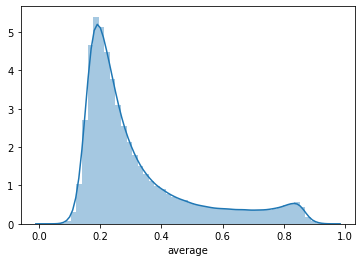

In [19]:
import seaborn as sns

sns.distplot(df["average"]);

What about the stds?

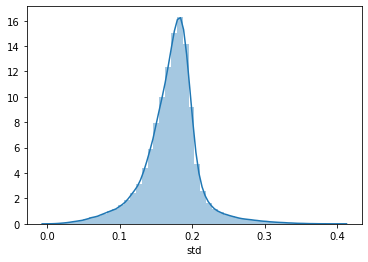

In [20]:
sns.distplot(df["std"])


Remember that given the mean $\mu$ and the std $\sigma$ (and asumming normality of the data) we have the predictions with a 0.68 confidence interval in $(\mu-\sigma, \mu+\sigma)$, and a 0.95 if two sigma are taken.

A simple approach I think would be to do the following:

- First, keep just the tweets with $\sigma \leq \epsilon$ ($\epsilon$ could be, 0.15)
- Label as offensive those with $\mu > (0.5 + \epsilon)$, so you got at least a 0.68 confidence interval that the mean is above 0.5
- Label as not offensive those with $\mu < 0.5 - \epsilon$ for the same reason
- Discard the others

Another strategy would be to fit our models using real cross entropy loss. That is, instead of training against a binary label use `average` as target output. 

## OLID Dataset

This dataset will be used as development dataset

Copy-pasting some of the data in `data/olid/README.txt`:


1) DESCRIPTION

This is the README file for OLID described in: https://arxiv.org/abs/1902.09666

OLID contains 14,100 annotate tweets. It has been used as the official dataset for OffensEval: Identifying and Categorizing Offensive Language in Social Media (SemEval 2019 - Task 6): https://competitions.codalab.org/competitions/20011

The files included are: 

- olid-training-v1.tsv contains 13,240 annotated tweets. 
- olid-annotation.txt contains a short summary of the annotation guidelines.
- testset-levela.tsv contains the test set instances of level a.
- testset-levelb.tsv contains the test set instances of level b.
- testset-levelc.tsv contains the test set instances of level c.
- labels-levela.csv contains the gold labels and IDs of the instances in test set layer a.
- labels-levelb.csv contains the gold labels and IDs of the instances test set layer b.
- labels-levelc.csv contains the gold labels and IDs of the instances test set layer c.

The dataset was annotated using crowdsourcing. The gold labels were assigned taking the agreement of three annotators into consideration. No correction has been carried out on the crowdsourcing annotations. 

Twitter user mentions were substituted by @USER and URLs have been substitute by URL.

OLID is annotated using a hierarchical annotation. Each instance contains up to 3 labels each corresponding to one of the following levels:

- Level (or sub-task) A: Offensive language identification; 

- Level (or sub-task) B: Automatic categorization of offense types;

- Level (or sub-task) C: Offense target identification.	

In [21]:
df_olid = pd.read_table("../data/olid/olid-training-v1.0.tsv", index_col=0)

df_olid.sample(2)

,tweet,subtask_a,subtask_b,subtask_c
id,,,,
44561,@USER Laws not just for Conservatives or an unpopular group with the Media. Women have long failed other women and the Me Too is no more sincere than the Feminist movement was about Bill Clinton or Ted Kennedy.,NOT,NaN,NaN
35524,Was this a threat from @USER #DangerousDemocrats #maga URL,OFF,TIN,OTH


Why is a tweet considered offensive? 

The annotation guidelines are not quite explicit...

```

*Rules & Tips*
Please rate the tweet according to whether it is offensive generally or to the target, not whether you are personally offended by it.
```


In [31]:
print(f"There are {df_olid.shape[0]} instances\n\nClass balance:")
df_olid["subtask_a"].value_counts(normalize=True)

There are 13240 instances

Class balance:


NOT    0.667674
OFF    0.332326
Name: subtask_a, dtype: float64

## Other languages

In [48]:
dfs = {
    "arabic": pd.read_table("../data/Arabic/offenseval-ar-training-v1.tsv", index_col=0),
    "arabic-dev": pd.read_table("../data/Arabic/offenseval-ar-dev-v1.tsv", index_col=0),
    "danish": pd.read_table("../data/Danish/offenseval-da-training-v1.tsv", index_col=0),
    "greek":  pd.read_table("../data/Greek/offenseval-greek-training-v1.tsv", index_col=0),
    "turkish": pd.read_table("../data/Turkish/offenseval-tr-training-v1.tsv", index_col=0) 
}


for lang, df_lang in dfs.items():
    print("="*80, "\n")
    print(f"There are {df_lang.shape[0]} instances for {lang}")
    print(f"Columns = {df_lang.columns}\n")
    
    print("Class balance")
    print(df_lang["subtask_a"].value_counts(normalize=True), "\n")
    
    print("Example tweets")
    print(df_lang.sample(2)["tweet"])


There are 6839 instances for arabic
Columns = Index(['tweet', 'subtask_a'], dtype='object')

Class balance
NOT    0.799532
OFF    0.200468
Name: subtask_a, dtype: float64 

Example tweets
id
2337                          يا ساكن قلبي يا عيوني الثنتين أحبك.
4923    RT @USER: فيس -واتس - انستا : يا بن المحظوظه يا تويتر URL
Name: tweet, dtype: object

There are 1000 instances for arabic-dev
Columns = Index(['tweet', 'subtask_a'], dtype='object')

Class balance
NOT    0.821
OFF    0.179
Name: subtask_a, dtype: float64 

Example tweets
id
7567                                                                                                       RT @USER: يا نادر بينهم ، يا اغلاهم💗💕 ..
7881    @USER هو السؤال يا منصف يا عادل كرة محمود علاء التى عرقل فبها المهاجم وهو منفرد الا يستحق الانذار التانى والطرد<LF>الكره هل عدت الخط ولا لا
Name: tweet, dtype: object

There are 2961 instances for danish
Columns = Index(['tweet', 'subtask_a'], dtype='object')

Class balance
NOT    0.87027
OFF    0.1297